# Introduction


My baseline builds on the `4lang` project available on github: [Link](https://github.com/kornai/4lang).
Our idea was to use the concept of the 4lang graphs discussed in paper: [Link](http://real.mtak.hu/46059/1/324_Paper.pdf)

In this notebook I only present the client side of our baseline, the code of the webservice built from the 4lang system will be available soon as well. I will present a simple way of using the 4lang graphs for inference. For this task we can calculate similarities among the graphs edges built from the premise and the hypothesis sentences.

Let's say we have a __premise__ sentence:

`My poor wife!`

and a __hypothesis__ sentence:

`I feel bad for my wife!`

then we can run the text_to_4lang tool to generate the graphs from the sentences. From these sentences we generate the following graphs:


    premise:
![premise](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045eprem.png?raw=true)

    hypothesis:
![hypothesis](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045ehyp.png?raw=true)

From the sentences we can already have an anticipation that these sentences are very similar, so the __hypothesis__ sentence will be an __entailment__ . So if we are ready to make an assumption an inference corresponds with the similarity of the graphs's edges, than in this case the graphs tells us that this is indeed an __entailment__ . 


This simple method works for a lot of examples, but if we want higher accuracy, we need to define finer techniques. This is where the definitions of the words come into play.


Currently our service has six endpoints, with each of them representing different methods:
- `<url>/pair/<Id>` - Returns the graphs built from the sentences.
- `<url>/pair_expand/<Id>` - Returns the graphs, where the word's definition has been added to the graph.
- `<url>/pair_abstract/<Id>` - Calling this function, we defined some rules, where we can build a more abstract graph using the definitions.
- `<url>/sym/<Id>` - Returns the similarity between two graphs.
- `<url>/sym_expand/<Id>` - Returns the similarity between two expanded graphs.
- `<url>/sym_abstract/<Id>` - Returns the similarity between two abstracted graphs.


In [1]:
import json

In [2]:
import requests

In [3]:
'''
First, to show how the service works we process the nli data to get the sentences and the corresponding gold labels(to simplify
things we reduce the task to a binary classification where we want to distinguish "neutral" and "entailment" sentences.)
'''
with open("multinli_1.0_train.jsonl", "r+") as f:
    labels = {}
    hypothesis = {}
    premise = {}
    count = 0
    for line in f:
        if count == 5000:
            break
        count = count + 1
        j = json.loads(line)
        if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
            pairId = j["pairID"]
            labels[pairId] = j["gold_label"]
            premise[pairId] = j["sentence1"]
            hypothesis[pairId] = j["sentence2"]

In [163]:
'''
Say we have the following sentence pairs, and we want to compute if it is an entailment or not.
'''
print(premise['117000e'])
print(hypothesis['117000e'])

And in between, you'll come upon the historic towns of Toulouse, Albi, and Montpellier.
You will pass through the historic towns of Toulouse, Albi, and Montpellier on your way to the final destination.


In [37]:
'''
The first request gets the similarity between the expanded graphs build from the sentences and the second works only
with the above defined default graphs, we can see that there are higher score if we expand our graph with the definition graph.
'''
urldot = url + 'pairexp/' + '117000e'
requests.get(urldot)
urlsim = url + 'symexp/' + '117000e'
pred = requests.get(urlsim)
print(pred.json())

urldot = url + 'pair/' + '117000e'
requests.get(urldot)
urlsim = url + 'sym/' + '117000e'
pred = requests.get(urlsim)
print(pred.json())

0.352941176471
0.3125


# Expanded Graphs

We said we wanted higher accuracy, so we take word definitions into account. We hope that with this method we can have higher similarites between graphs whose sentences are also similar. Let's look at the __premise__ sentence discussed in the introduction section:

`My poor wife!`

    and the corresponding graph:

![premise](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045eprem.png?raw=true)

if we know that the word __poor__ definition is : _having very little money and not many possessions_ we can build a definition graph and essentially join the two graphs together doing this for every word in the sentence:

![expanded](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045eprem_expand.png?raw=true)

this way the expanded graph gives us much more accurat context and definition.

In [164]:
'''
It's our task to set a threshold to what we consider an entailment, I initialized a list with different scores, so we can have a
more accurat look at the results
'''
support = [0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [182]:
'''
First we initialize our graphs, so we can efficiently work with them later
'''
def init_graphs():
    with open("multinli_1.0_train.jsonl", "r+") as f:
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                
                pairId = j["pairID"]
                
                urldot = url + 'pair/' + pairId
                requests.get(urldot)
                urlexp = url + 'pairexp/' + pairId
                requests.get(urlexp)
                
                urlabs = url + 'pair_abstract/' + pairId
                requests.get(urlabs)
                

In [66]:
'''
We process our data and get the gold labels to the y_true list, after that we call our webservice to return the predicted score
calculated on the default graphs
'''
def return_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsim = url + 'sym/' + pairId
                pred = requests.get(urlsim)
                if float(pred.json()) > supportscore :
                    y_pred.append(1)
                else:
                    y_pred.append(0)
                
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred.count(1)]

In [42]:
'''
Essentially the same as above, only on expanded graphs.
'''
def return_expanded_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred_exp = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsimexp = url + 'symexp/' + pairId
                pred = requests.get(urlsimexp)
                if float(pred.json()) > supportscore :
                    y_pred_exp.append(1)
                else:
                    y_pred_exp.append(0)
                
    accuracy = accuracy_score(y_true, y_pred_exp)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_exp, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred_exp.count(1)]

# Abstract graphs

If we go back to the __premise__ sentence discussed above, and get the expanded graph:

![expanded](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045eprem_expand.png?raw=true)

In this example if we look at the edge __wife__ --> __woman__ with __label__:0 we can make an assumption that within the boundaries of the sentence we can use the concept __woman__ instead of the concept __wife__ . Using this simple rule we can reduce our graph to a simpler definition:

![abstract](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/127045eprem_abstract.png?raw=true)

Following this logic we initially made three simple rules:

If we have a machine, and its definition graphs, where:
- Def --> X is present with label: 0 than we can use X instead of Def machine
- X --> Def is present with label: 0 than we can use X instead of Def machine again.
- If we have Y <-- Def --> X with labels: 1,2 both in the definition and the sentence graph, than we can connect every edge from X and Y from the definition graph to the sentence graph

For the third rule:

Let's have the following graph:

![default](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/default.png?raw=true)

and say we have the definition of the concept __increase__ in the following graph:

![increase](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/expanded.png?raw=true)

than by the rule number 3 we can add the following additional edges to the __price__ concept:

![price](https://github.com/recski/semantic_parsing_szte_bme/blob/master/nli_baselines/Adam/images/abstract.png?raw=true)

In [172]:
'''
In this method we defined, how we return the similarity score, it has a single argument, the threshold value
(because We only want to test our methods, I only used a test sample of 5000 sentences). After we calculated the similarity scores
we return f1-score, precision, recall and the accuracy.
'''
def return_abstract_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred_abs = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsimexp = url + 'sym_abstract/' + pairId
                pred = requests.get(urlsimexp)
                if float(pred.json()) > supportscore :
                    y_pred_abs.append(1)
                else:
                    y_pred_abs.append(0)
                
    accuracy = accuracy_score(y_true, y_pred_abs)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_abs, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred_abs.count(1)]

In [67]:
#Importing pyplot, and calling the default scores function, and we draw a simple diagram from the results
from matplotlib import pyplot as plt

accuracies = []
precisions = []
recals = []
f1_scores = []
entailments = []

for i in support:
    scores = return_scores(i)
    accuracies.append(scores[0])
    precisions.append(scores[1])
    recals.append(scores[2])
    f1_scores.append(scores[3])
    entailments.append(scores[4])


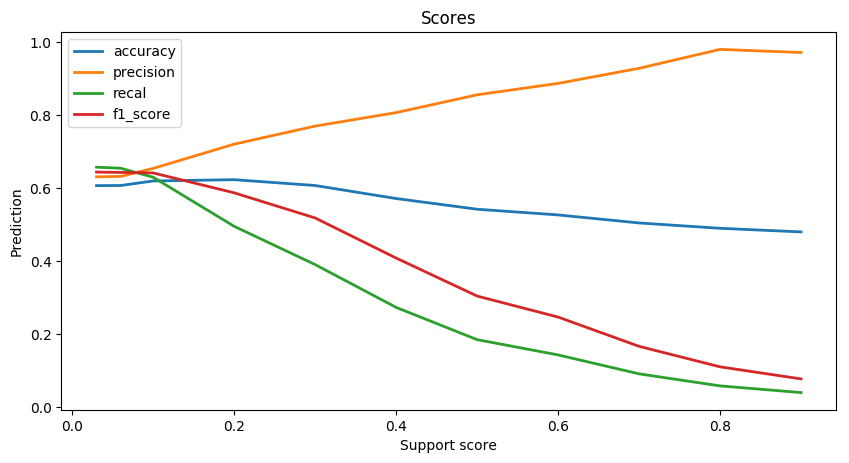

In [70]:
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies,label='accuracy',linewidth=2)
plt.plot(support,precisions,label='precision',linewidth=2)
plt.plot(support,recals,label='recal',linewidth=2)
plt.plot(support,f1_scores,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted, we can see we achieved pretty good values with ~0,62 f1_score and accuracy
#Interesting thing to notice is that if we had some edge similarity, raising the threshold value doesnt change the result.
plt.show()

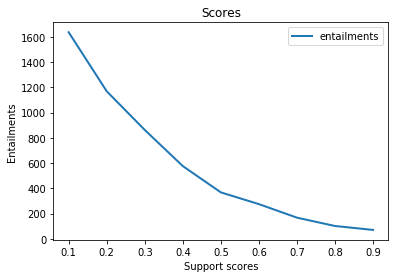

In [57]:
plt.plot(support,entailments,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

In [ ]:
#We are doing the same as above just only for expanded graphs. We achieved better results with this method, with f1_score
#coming near to ~0.7 percent.
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
accuracies_exp = []
precisions_exp = []
recals_exp = []
f1_scores_exp = []
entailments_exp = []

for i in support:
    scores = return_expanded_scores(i)
    accuracies_exp.append(scores[0])
    precisions_exp.append(scores[1])
    recals_exp.append(scores[2])
    f1_scores_exp.append(scores[3])
    entailments_exp.append(scores[4])

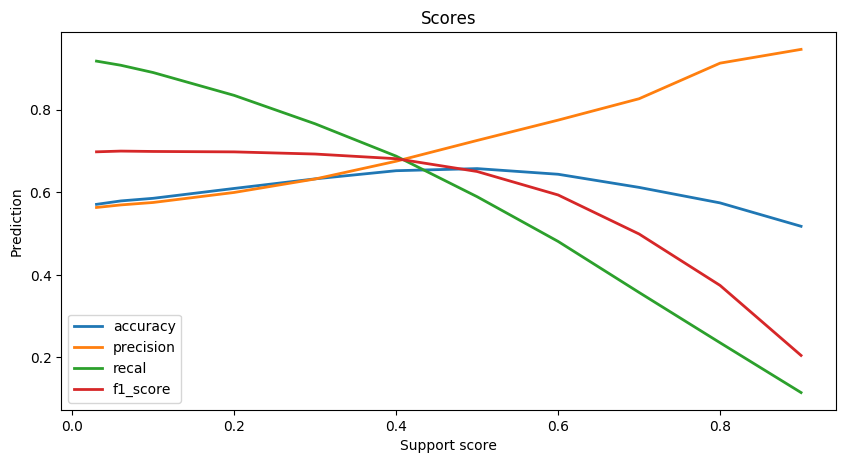

In [46]:
from matplotlib import pyplot as plt
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies_exp,label='accuracy',linewidth=2)
plt.plot(support,precisions_exp,label='precision',linewidth=2)
plt.plot(support,recals_exp,label='recal',linewidth=2)
plt.plot(support,f1_scores_exp,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted
plt.show()

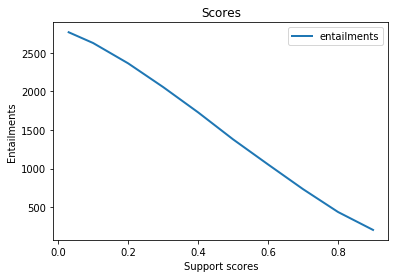

In [47]:
plt.plot(support,entailments_exp,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

In [184]:
#Doing the same for abstracted graphs, it is only a test result, because here the graphs only used the first rule.
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
accuracies_abs = []
precisions_abs = []
recals_abs = []
f1_scores_abs = []
entailments_abs = []

for i in support:
    scores = return_abstract_scores(i)
    accuracies_abs.append(scores[0])
    precisions_abs.append(scores[1])
    recals_abs.append(scores[2])
    f1_scores_abs.append(scores[3])
    entailments_abs.append(scores[4])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096


3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785


368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617


2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398


3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050


648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897


2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624


4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277


929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1

2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806


4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449


1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381


2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069


4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714


1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634


3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277


4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982


1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865


3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
28

1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075


3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768


356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605


2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356


3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056


689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938


2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618


4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326


1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229


2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904


4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589


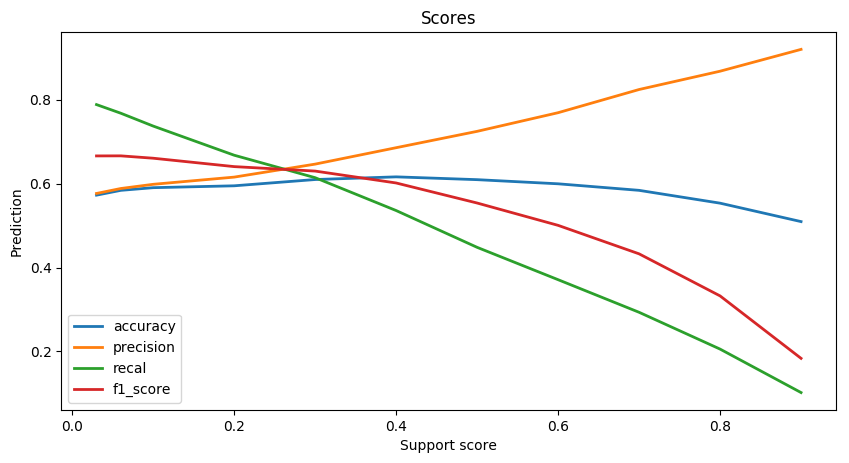

In [185]:
from matplotlib import pyplot as plt
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies_abs,label='accuracy',linewidth=2)
plt.plot(support,precisions_abs,label='precision',linewidth=2)
plt.plot(support,recals_abs,label='recal',linewidth=2)
plt.plot(support,f1_scores_abs,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted
plt.show()

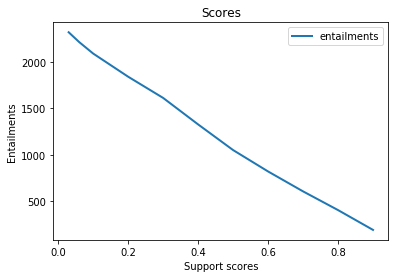

In [186]:
plt.plot(support,entailments_abs,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

# ONLY TESTING SOME SMALL EXAMPLES

In [11]:
url = 'http://127.0.0.1:5000/'
inp = ['93208e', '102167e', '30868n', '119952e', '141334n', '50602n', '134042e', '20566e', '33940n','33940n','52785e',
       '120818n', '50720e', '139990e', '43516n', '31012e', '99278n', '125407n', '18015n', '103287e', '81497e', '39339n']
inp2 = ['102167e']
for i in inp:
    urlsim = url + 'pair_abstract/' + i
    pred = requests.get(urlsim)

In [14]:
import json
with open("multinli_1.0_train.jsonl", "r+") as f:
    labels = {}
    hypothesis = {}
    premise = {}
    y_true = []
    y_pred = []
    small_sentences = []
    count = 0
    for line in f:
        if count == 5000:
            break
        count = count + 1
        j = json.loads(line)
        if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
            pairId = j["pairID"]
            labels[pairId] = j["gold_label"]
            premise[pairId] = j["sentence1"]
            hypothesis[pairId] = j["sentence2"]
            if j["gold_label"] == "entailment":
                y_true.append(1)
            elif j["gold_label"] == "neutral":
                y_true.append(0)
            if len(premise[pairId].split()) < 7 and len(hypothesis[pairId].split()) < 7:
                small_sentences.append(pairId)

In [159]:
print(premise['127045e'])
print(hypothesis['127045e'])

My poor wife! 
I feel bad for my wife!


In [156]:
inp = ['19833e',
'7479e',
'85687e',
'98513e',
'141786e',
'18626e',
'116210e',
'41414e',
'91281e',
'127045e']

In [158]:
url = 'http://127.0.0.1:5000/'
for i in inp:
    urlsim = url + 'pair_abstract/' + i
    pred = requests.get(urlsim)

In [142]:
print(premise['19833e'])
print(hypothesis['19833e'])

The next witness was Mary Cavendish. 
There was another witness.


In [120]:
url = 'http://127.0.0.1:5000/'
for i in inp:
    urlabs = url + 'sym_abstract/' + i
    urlexp = url + 'symexp/' + i
    urlsim = url + 'sym/' + i
    predabs = requests.get(urlabs)
    predsim = requests.get(urlsim)
    predexp = requests.get(urlexp)
    print("pred_abs:" + i)
    print(predabs.json())
    print("pred_sim:" + i)
    print(predsim.json())
    print("pred_exp:" + i)
    print(predexp.json())

pred_abs:19833e
0.45
pred_sim:19833e
0
pred_exp:19833e
0.571428571429
pred_abs:7479e
0
pred_sim:7479e
0
pred_exp:7479e
0
pred_abs:85687e
0.953488372093
pred_sim:85687e
0
pred_exp:85687e
0.736842105263
pred_abs:98513e
0.2
pred_sim:98513e
0.333333333333
pred_exp:98513e
0.0769230769231
pred_abs:141786e
0
pred_sim:141786e
0
pred_exp:141786e
0
pred_abs:18626e
0.310344827586
pred_sim:18626e
0
pred_exp:18626e
0.2
pred_abs:116210e
0.105263157895
pred_sim:116210e
0
pred_exp:116210e
0
pred_abs:41414e
0.454545454545
pred_sim:41414e
0
pred_exp:41414e
0.333333333333


In [194]:
def return_error_graphs():
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        errors_high = []
        errors_low = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                                
                urlsimexp = url + 'sym_abstract/' + pairId
                pred = requests.get(urlsimexp)
                
                if float(pred.json()) > 0.6 and j["gold_label"] == "neutral":
                    errors_high.append((pairId, float(pred.json())))
                elif float(pred.json()) <= 0.001 and j["gold_label"] == "entailment":
                    errors_low.append((pairId, float(pred.json())))
        return errors_high, errors_low

In [195]:
er_h, er_low = return_error_graphs()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092


3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811


In [199]:
print(er_h)

[(u'50563n', 0.888888888889), (u'32819n', 0.717391304348), (u'87912n', 0.75), (u'77527n', 0.666666666667), (u'22132n', 0.710526315789), (u'78697n', 0.666666666667), (u'14868n', 0.769230769231), (u'102911n', 0.826446280992), (u'117164n', 0.627450980392), (u'66331n', 0.647058823529), (u'33519n', 0.791666666667), (u'119476n', 0.916666666667), (u'114411n', 0.9), (u'46033n', 0.739130434783), (u'95566n', 0.676470588235), (u'126269n', 0.7), (u'5487n', 0.625), (u'3272n', 0.909090909091), (u'52708n', 0.63829787234), (u'63075n', 0.769230769231), (u'55825n', 0.851063829787), (u'83616n', 0.777777777778), (u'117949n', 0.611940298507), (u'85148n', 0.714285714286), (u'141081n', 0.736842105263), (u'10036n', 0.8), (u'42380n', 0.625), (u'63092n', 0.77358490566), (u'22860n', 0.709677419355), (u'40286n', 0.666666666667), (u'136765n', 0.611111111111), (u'122784n', 0.833333333333), (u'9333n', 0.823529411765), (u'106779n', 0.816326530612), (u'42104n', 0.897959183673), (u'68412n', 1.0), (u'59783n', 0.82758620

In [202]:
print(premise['50563n'])
print(hypothesis['50563n'])

yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range
The tennis shoes have a range of prices.


In [203]:
print(premise['3272n'])
print(hypothesis['3272n'])

The others followed.
The others had followed Jon.


In [204]:
print(premise['119476n'])
print(hypothesis['119476n'])

It covers most but not all close Senate and gubernatorial races.)
The radio station covers most close gubernatorial races


In [217]:
with open("errors_low.txt", "w+") as f:
    for i in er_low:
        f.write('{}{}{}{}'.format('\nid: ' + str(i[0]) + '\n' + 'score: ' + str(i[1]) + '\n','premise: ' + premise[i[0]].encode("utf8"), '\n', 'hyp: ' + hypothesis[i[0]].encode("utf8") + '\n'))

In [221]:
print(len(er_h))

189


In [26]:
url = 'http://127.0.0.1:5000/'
urlexp = url + 'pair_abstract/' + '47327e'
requests.get(urlexp)

<Response [200]>

In [17]:
urlexp = url + 'symexp/' + '47327e'
resp = requests.get(urlexp)

In [14]:
print(resp.json())

0
